# Building makemore: becoming a backprop ninja

https://www.youtube.com/watch?v=q8SA3rM6ckI

Before going to more complicated networks, one more lecture to really understand the backpropagation step. Can't just automatically stack together differentiable functions and expect it to work; can shoot ourselves in the foot if internal mechanisms aren't understood. Need to understand under the hood to debug it.

Flat tails like tanh and sigmoid lead to gradient issues (vanishing gradients), dead neurons, and other problems we saw before. Can't really debug without understanding what `loss.backwards()` actually does.

We covered autograd in the micrograd lecture; good exercise to redo in the language of tensors.

# Some history

Pre-2012 people wrote their own, but now that doesn't really happen anymore. 2010 package Andrej wrote for Matlab - created tensors and fit RBMs (restricted Boltzmann machines) and trained by estimating gradient, not backprop we're used to.

2014 paper: defragmented embeddings. Code was in Python implementing cost function and backward pass manually, and backpropagation result compared to a "gradient checker" to see if numerically the results were close to the estimate.

# Starter code

In [1]:
# there no change change in the first several cells from last lecture

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# ok biolerplate done, now we get to the action:

# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

This function is used to check for correctness of our implementation versus the "official" Pytorch result.

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


Note biases are set to small random numbers; we're not using 0 because that would hide potential issues with how we're computing gradients and doing backprop.

In [7]:
# Creating a single batch
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
# Note how much longer this is than the F.cross_entropy() implementation
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3244, grad_fn=<NegBackward0>)

This forward pass code is much longer than before. The cross-entropy part is expanded into many chunks, and the whole process is expanded with many more intermediate steps. That'll help calculate individual gradients at each step, bottom to top.

In [9]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# Use cmp() functions to check the correctness at each step.

We want to manually compute each of these derivatives. For example:

$\text{Loss} = \sum_{i=1}^{n}\frac{x_i}{n} $
$\implies$
$\frac{d\text{Loss}}{dx_i} = \frac{1}{n}$

for each $x_i$.

In [10]:
dlogprobs = torch.zeros_like(logprobs) # Sets zeros in shape of logprobs
dlogprobs[range(n), Yb] = -1.0/n

cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Going on to the other terms:

In [12]:
# Use result previously computed above
cmp('logprobs', dlogprobs, logprobs)

# logprobs = probs.log()
# Log transformation; derivative of ln(x) is 1/x
# Use the chain rule
dprobs = (1 / probs) * dlogprobs
cmp('probs', dprobs, probs)

# probs = counts * counts_sum_inv
# Derivative would just be counts
# Try: dcounts_sum_inv = counts * dprobs
# That doesn't work due to broadcasting of counts * counts_sum_inv, which have different dimensionality
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# Compute dcounts_sum next, before moving on to dcounts
# counts_sum_inv = counts_sum**-1
# d/dx x^-1 = -x^-2
dcounts_sum = (-1.0 / counts_sum**2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# dcounts has two components
# 1) probs = counts * counts_sum_inv
# Similar to probs, but derivative is now counts_sum_inv
dcounts = counts_sum_inv * dprobs
# 2) counts_sum = counts.sum(1, keepdims=True)
# Derivative "flows" equally to all components of the sum; need to account for shape of tensor
dcounts += torch.ones_like(counts) * dcounts_sum 
cmp('counts', dcounts, counts)

# counts = norm_logits.exp()
# d/dx exp(x) = exp(x)
# Shortcut: just reuse counts, which is defined as exp(norm_logits) already
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# norm_logits = logits - logit_maxes
# Subtraction: derivative is -1
# Need to specify shape of tensor due to "broadcasting"
dlogit_maxes = -dnorm_logits.sum(1, keepdim = True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

# dlogits has two components
# 1) norm_logits = logits - logit_maxes
# Addition; derivative is just 1; similar to dcounts
dlogits = dnorm_logits.clone()
# 2) logit_maxes = logits.max(1, keepdim=True).values
# Derivative of the max is 1 * (element pulled out); scattering max value into appropriate index
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0


Aside: banching through logit_maxes, the values there shouldn't matter with respect to the final loss (gradient 0) which is by design. Add that term for numerical stability during the softmax transformation; just making sure we don't have overflow issues. Sure enough the values are extremely small (gradient near 0):

In [44]:
print(dlogits)

tensor([[-1.8626e-09],
        [-9.3132e-10],
        [ 1.8626e-09],
        [-3.7253e-09],
        [ 2.7940e-09],
        [-2.3283e-09],
        [ 4.6566e-10],
        [ 4.6566e-09],
        [-9.3132e-10],
        [-5.3551e-09],
        [ 0.0000e+00],
        [ 9.3132e-10],
        [ 3.2596e-09],
        [-2.7940e-09],
        [-1.8626e-09],
        [-7.9162e-09],
        [ 4.6566e-10],
        [ 2.3283e-09],
        [ 1.3970e-09],
        [ 4.6566e-10],
        [ 2.3283e-09],
        [-1.8626e-09],
        [ 4.6566e-09],
        [-9.3132e-10],
        [ 1.8626e-09],
        [ 4.6566e-10],
        [ 2.0955e-09],
        [ 4.6566e-10],
        [-1.8626e-09],
        [ 3.0268e-09],
        [-1.8626e-09],
        [-2.3283e-09]], grad_fn=<SumBackward1>)


In [ ]:
# logits = h @ W2 + b2
# Note that @ is the matrix multiplication operation in Python
# Rows of h times columns of W2: need to pull out corresponding elements and sum
# Which can in and of itself be expressed as a matrix multiplication operation
# Multiplication: d/dh logits = dL/dd @ t(b)
# But in practice you can check the shape of the matrices and figure out what should be transposed
dh = dlogits @ W2.T
cmp('h', dh, h)

# logits = h @ W2 + b2
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

# logits = h @ W2 + b2
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

In [23]:
print( "dlogits: " + str(dlogits.shape))
print("h: " + str(h.shape))
print("W2: " + str(W2.shape))
print("b2: " + str(b2.shape))

dlogits: torch.Size([32, 27])
h: torch.Size([32, 64])
W2: torch.Size([64, 27])
b2: torch.Size([27])


Looking at the dimensions gives a hint about the correct matrix operation at each step.

Continuing:

In [42]:
# h = torch.tanh(hpreact)
# Derivative for tanh from earlier lectures:
# d/dx tanh(x) = 1 - tanh(x)^2
dhpreact = (1 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

# Onto the batchnorm layers
# hpreact = bngain * bnraw + bnbias
# Just another multiplication backprop; need to fix shape
dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
cmp('bngain', dbngain, bngain)

# hpreact = bngain * bnraw + bnbias
# Just another multiplication backprop
dbnraw = (bngain * dhpreact)
cmp('bnraw', dbnraw, bnraw)

# hpreact = bngain * bnraw + bnbias
# Just another sum backprop
dbnbias = dhpreact.sum(0, keepdim = True)
cmp('bnbias', dbnbias, bnbias)

# Some of the batchnorm terms have multiple components
# bnraw = bndiff * bnvar_inv
# Need to account for dimensions of tensor as before
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
# Chain rule: d/dx x^a = a*x^(a-1)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# Derivative of the summation is just 1; use the torch.ones_like
# trick to make a tensor of 1 of the correct size
dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bnvar           | exact: True  | approximate: True  | maxdiff: 0.0
bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


What is the $(n-1)$ term in `dbndiff2`? This is Bessel's correction for computing the standard deviation. See https://math.oxford.emory.edu/site/math117/besselCorrection/

(When using the estimate of the variance to estimate the mean a degree of freedom was used up; the estimated variance when using $n$ will be too low.)

The paper this mini-batch approach is from was inconsistent, using the correction for estimating variance (when mean is unknown) in the results, but the biased version for training.

Apparently Pytorch implemented this exactly for Batchnorm and the documentation is inconsistent. Andrej prefers using $(n-1)$ at both training and test time.

In [63]:
# Two branches for bndiff
# 1) bnraw = bndiff * bnvar_inv
# This is just multiplication
dbndiff = bnvar_inv * dbnraw
# 2) bndiff2 = bndiff**2
dbndiff += (2 * bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

# bndiff = hprebn - bnmeani
# Just simple subtraction, easy derivative, then sum
dbnmeani = (-dbndiff).sum(0, keepdim = True)
cmp('bnmeani', dbnmeani, bnmeani)

# Two branches for hprebn
# 1) bndiff = hprebn - bnmeani
# Derivative of a sum is 1
dhprebn = dbndiff.clone()
# 2) bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# d/dx ax = a, and the sum uses the 1 trick
dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0
bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0
hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


For the last linear layer, we can look at the shapes again to see what needs to be multiplied intuitively.

In [65]:
print("hprebn: " + str(hprebn.shape))
print("embcat: " + str(embcat.shape))
print("W1: " + str(W1.shape))
print("b1: " + str(b1.shape))

hprebn: torch.Size([32, 64])
embcat: torch.Size([32, 30])
W1: torch.Size([30, 64])
b1: torch.Size([64])


In [78]:
# hprebn = embcat @ W1 + b1
# Multiplication: need dhprebn @ W1 in some arrangement
# (32, 64) * t(30, 64)
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

# hprebn = embcat @ W1 + b1
# Multiplication: embcat @ dhprebn
# t(32, 30) * (32, 64)
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

# hprebn = embcat @ W1 + b1
# Summation
db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

# embcat = emb.view(emb.shape[0], -1)
# Concatenates 3 vectors; we're just undoing this
# Need to view it as orignal shape
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0
emb             | exact: True  | approximate: True  | maxdiff: 0.0


Last step: need to unindex. Recall that initially we filled in character indices from the lookup table.

In [79]:
# Forward pass: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


Integers in Xb specify which row of C is used for the tensor.

In [80]:
# emb = C[Xb]
# Route back through the indexing - this requires a for loop
dC = torch.zeros_like(C)
# Iterate over Xb and pull tensors for the indices
for k in range(Xb.shape[0]): 
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
# Check results
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


Goal of exercise 2 is to analytically derive the correct function, which is much faster than doing the individual steps as above. Not necessary to go step by step because analytically, a lot of the steps cancel and it simplifies.

Can get dlogits directly.

In [81]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3243653774261475 diff: -7.152557373046875e-07


For the backward pass, after doing a bunch of arithmetic the components of the derivatives simplifies to either $p_i$ or $1 - p_i$.

In [82]:
# backward pass
dlogits = F.softmax(logits, 1)
# subtract 1 at all the correct positions
dlogits[range(n), Yb] -= 1
# take the average, divide by n at all positions
dlogits /= n
cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


This is essentially the same answer to rounding error.

Let's get some intuition for what dlogits is doing.

In [83]:
# First element of dlogits
dlogits[0] * n

tensor([ 0.0728,  0.0895,  0.0197,  0.0487,  0.0198,  0.0845,  0.0251,  0.0369,
        -0.9817,  0.0316,  0.0365,  0.0336,  0.0338,  0.0287,  0.0378,  0.0136,
         0.0100,  0.0197,  0.0169,  0.0555,  0.0445,  0.0214,  0.0244,  0.0710,
         0.0594,  0.0257,  0.0208], grad_fn=<MulBackward0>)

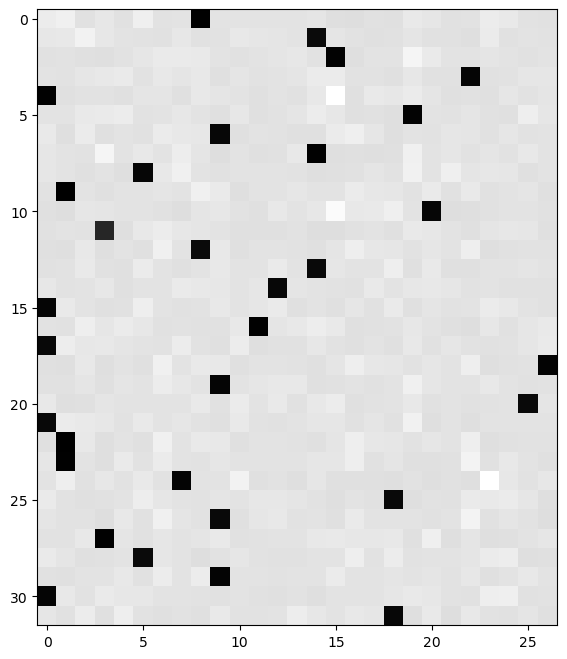

In [85]:
plt.figure(figsize = (8, 8))
plt.imshow(dlogits.detach(), cmap = 'gray')

Black squares are the positions of the correct indices: note that for 0th row the index at 9 is -1. Probability at incorrect characters is pulled down, probability at correct character is pushed up. Training the neural network is like pushing and pulling correctly on the vectors to get closer to the correct answer.

Amount of "force" applied is proportional to the loss from the forward pass. A confident misprediction leads to everything but the correct answer being strongly pulled toward 0.

Goal of exercise 3 is to do derivation through a batchnorm layer.

In [86]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [88]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

Need to take partial derivatives over each of the parameters from the paper.

$ \mu = \frac{1}{n} \sum{x_i} $

$ \sigma^2 = \frac{1}{n-1}\sum{(x_i - \mu )^2} $

$ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $

$ y_i = \gamma_i \hat{x}_i + \beta $

Lots of derivatives and substitutions and it all simplifies to:

In [87]:
# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# Tricky part of the code is everything has to "broadcast" with the correct shapes; non-trivial to prove

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


Final step is pasting our own backprop code and get it training.

In [89]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8312
  10000/ 200000: 2.1709
  20000/ 200000: 2.4078
  30000/ 200000: 2.4702
  40000/ 200000: 2.0049
  50000/ 200000: 2.4405
  60000/ 200000: 2.3187
  70000/ 200000: 1.9989
  80000/ 200000: 2.3290
  90000/ 200000: 2.1815
 100000/ 200000: 1.9603
 110000/ 200000: 2.3461
 120000/ 200000: 2.0194
 130000/ 200000: 2.4891
 140000/ 200000: 2.2673
 150000/ 200000: 2.1853
 160000/ 200000: 1.9678
 170000/ 200000: 1.7846
 180000/ 200000: 1.9524
 190000/ 200000: 1.8605


This takes quite a bit longer to run than using the built-in implementation, of course, but the loss is comparable to using Pytorch's backward pass.

Each layer only takes a few lines of code to do the backward pass. Of course in practice you'd still use Pytorch's loss.backward()

In [90]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [91]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068781852722168
val 2.1075339317321777


In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
madhayla.
renyla.
endraege.
derronelin.
shi.
jen.
eden.
sana.
arleigh.
malaia.
noshubergihiriel.
kin.
renlee.
jose.
casuna.
geder.
yarul.


I see a couple real names there! Nice milestone for the Swole Doge.